# Jacobi and Gauss-Seidel

Implementing linear solvers with numpy and numba

---

The conclusions in this notebook can vary with the computer use. Intel architectures and the new Apple M1 chip will see different results. Additionally, processors with few cores (such as those you can get cheaply on cloud platforms) won't see any gains with parallelism. In fact, the overhead of parallelism will actually make the algorithm slower.

The behaviour of every implementation also varies with the problem size. I encourage you to use different values of $n$ at very different scales: solving a problem of size $n = 10$ is qualitatively very different from solving a problem of size $n = 2000$ or $n = 10000$.

---

A little warning: running the line profiler on Apple silicon causes a segmentation fault. The package is probably precompiled for Intel architectures.

In [133]:
%%capture

import sys
!{sys.executable} -m pip install numpy numba line_profiler scipy matplotlib

In [134]:
# %load_ext line_profiler

In [135]:
import numpy as np
from numpy.linalg import norm
import numpy.random as rng
import matplotlib.pyplot as plt

Always check for correctness of your algorithms before optimizing them !

In [136]:
def correct(f):
    n = 100
    A = rng.normal(size=(n, n)) + np.eye(n) * np.sqrt(n * 3)
    b = rng.normal(size=(n))

    x = f(A, b)
    return np.allclose(np.dot(A, x), b)

The next function is a utility to plot the time an implementation takes for various problem sizes.

In [137]:
def curve(*fs):
    x = np.asarray([10, 100, 300, 500, 1000, 2000, 5000, 10000])

    # measure on the same problems to avoid more randomness
    problems = {
        n: ((rng.normal(size=(n, n)) + np.eye(n) * np.sqrt(n * 3)), (rng.normal(size=(n))))
        for n in x
    }

    for f in fs:
        print(f.__name__)
        avgs = []
        for n in x:
            A, b = problems[n]
            res = %timeit -o f(A, b)
            avgs.append(res.average)

        plt.loglog(x, avgs, label=f.__name__)
        print('---')

    plt.legend()
    plt.show()

## Jacobi algorithm

### Numpy implementation

Let's start with a seemingly reasonable numpy implementation of the Jacobi algorithm.

In [138]:
MAXIT = 1000


def jacobi_np(A, b):
    D = np.diag(A)
    T = (np.diag(D) - A)
    T = T / np.expand_dims(D, 1)
    c = b / D

    x = np.zeros_like(b)
    for _ in range(MAXIT):

        ox = x.copy()
        x[:] = np.dot(T, x) + c

        if norm(x - ox) / norm(x) < 1e-9:
            break
    
    return x

In [139]:
assert correct(jacobi_np)

jacobi_np
163 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
758 µs ± 210 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.01 ms ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.84 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.77 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.5 ms ± 848 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
208 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
887 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
---


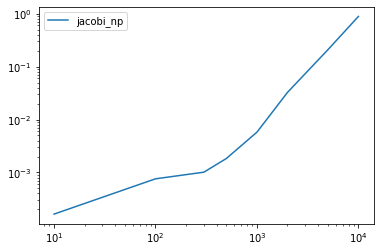

In [114]:
curve(jacobi_np)

Intuitively one would think the bottleneck of this algorithm is the iterative phase. It is indeed the core of the computation. However by profiling we discover the slowest part is actually creating the `T` matrix. Indeed, dividing by $D$ is an $\mathcal{O}(n^2)$ operation.

In [140]:
# %lprun -f jacobi_np jacobi_np(A, b)

Let's optimize the artificially slow part.

In [141]:
def jacobi_np_2(A, b):
    D = np.diag(A)
    c = b

    x = np.zeros_like(b)
    for _ in range(MAXIT):

        ox = x.copy()
        x[:] = (- np.dot(A, x) + D * x + c) / D

        if norm(x - ox) / norm(x) < 1e-9:
            break
    
    return x

In [142]:
assert correct(jacobi_np_2)

On Intel and Apple M1 machines `jacobi_np_2`is twice as fast as `jacobi_np`, and the advantage grows with problem size.

jacobi_np
253 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
809 µs ± 108 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.07 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.79 ms ± 611 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.05 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
34.6 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
241 ms ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
967 ms ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
---
jacobi_np_2
334 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.02 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.39 ms ± 500 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.39 ms ± 57.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.17 ms ± 695 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.6 ms ± 1.56 ms per loop (mean ± std. dev. of 7 r

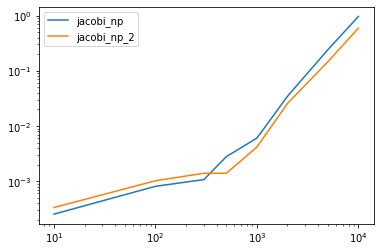

In [143]:
curve(jacobi_np, jacobi_np_2)

The results of the line profiler are now much more coherent.

In [119]:
# %lprun -f jacobi_np_2 jacobi_np_2(A, b)

### Numba comes in

Can numba accelerate our function out of the box ? On the machines I tested, the answer seems to be no for large problem sizes, but a resounding yes for smaller problem sizes.

In [144]:
from numba import njit, prange

jacobi_np_2
268 µs ± 3.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.29 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.23 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.88 ms ± 398 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.29 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26 ms ± 989 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
155 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
578 ms ± 5.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
---
jacobi_np_numba
28 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
349 µs ± 156 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
735 µs ± 169 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.23 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.92 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.6 ms ± 2.01 ms per loop (mean ± std. dev. of 

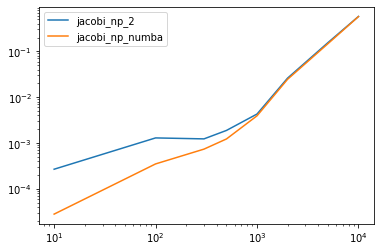

In [145]:
jacobi_np_numba = njit(jacobi_np_2)
jacobi_np_numba.__name__ = 'jacobi_np_numba'
assert correct(jacobi_np_numba)

curve(jacobi_np_2, jacobi_np_numba)

In [146]:
def jacobi_loop(A, b):
    x = b.copy()

    for _ in range(MAXIT):

        z = np.empty(len(b))
        for i in prange(b.shape[0]):
            z[i] = (- np.sum(A[i] * x) + A[i, i] * x[i] + b[i]) / A[i, i]
        
        ox = x.copy()
        x[:] = z

        if norm(x - ox) / norm(x) < 1e-9:
            break

    return x


jacobi_loop_numba = njit(fastmath=True, nogil=True)(jacobi_loop)
jacobi_loop_numba.__name__ = 'jacobi_loop_numba'

jacobi_loop_numba_parallel = njit(parallel=True, fastmath=True, nogil=True)(jacobi_loop)
jacobi_loop_numba_parallel.__name__ = 'jacobi_loop_numba_parallel'

In [147]:
assert correct(jacobi_loop_numba)
assert correct(jacobi_loop_numba_parallel)

Both of the new functions are faster ! By increasing the size of the problem we can really see the parallel version shine:

jacobi_np_2
293 µs ± 2.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
904 µs ± 129 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.08 ms ± 86.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.63 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.26 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
27.6 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
159 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
589 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
---
jacobi_np_numba
29.4 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
370 µs ± 158 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
581 µs ± 112 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.3 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.86 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.9 ms ± 2.33 ms per loop (mean ± std. de

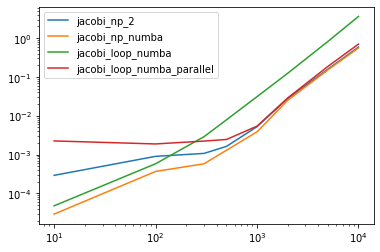

In [148]:
curve(jacobi_np_2, jacobi_np_numba, jacobi_loop_numba, jacobi_loop_numba_parallel)

Numba comes with a handy tool to understand the optimizations it applies to parallel algorithms. In our case, it seems the gains come from both parallelization and loop fusion. When we run the following line in numpy:

```py
x[:] = (- np.dot(A, x) + D * x + c) / D
```

we loop 3 times for each `x[i]`. Indeed, we loop:
1. for the dot product
2. for the addition
3. for the division

Every time we loop over the full array, our CPU stores the values in the cache temporarily and evicts them. The cache is not used optimally as each value is fetched and evicted 3 times ! We can improve "data locality" by fusing our loops: looping once and applying the three operations. This is one of the optimizations applied by numba.

Writing full loops can sometimes be necessary, notably for parallel code (the parallel loop is marked by `prange`). Numba often has an easier time optimizing our loops than understanding our numpy broadcasts.

In [130]:
jacobi_loop_numba_parallel.parallel_diagnostics(level=1)

 
 Parallel Accelerator Optimizing:  Function jacobi_loop, <ipython-
input-122-9e2ba289b937> (1)  


Parallel loop listing for  Function jacobi_loop, <ipython-input-122-9e2ba289b937> (1) 
--------------------------------------------------------------------------------|loop #ID
def jacobi_loop(A, b):                                                          | 
    x = b.copy()                                                                | 
                                                                                | 
    for _ in range(MAXIT):                                                      | 
                                                                                | 
        z = np.empty(len(b))                                                    | 
        for i in prange(b.shape[0]):--------------------------------------------| #41
            z[i] = (- np.sum(A[i] * x) + A[i, i] * x[i] + b[i]) / A[i, i]-------| #38, 40
                                                

## Gauss-Seidel algorithm

The first implementation is a rather reasonable numpy implementation of the Jacobi algorithm. The second is precisely the same code, but JIT compiled by numba. The third is loop based and numba accelerated. The fourth is loop based and numba accelerated with the parallel flag on (numba will attempt to parallelize loops marked with `prange`).

The attentive reader will observe the fourth implementation is not a correct implementation of Gauss-Seidel. Indeed, it is impossible to parallelize Gauss-Seidel and preserve the same semantics. But it seems that the (potential) disadvantages to embracing disorder in the updates of `x` is outweighed by the benefits of parallelization.

In [152]:
MAXIT = 1000


def gauss_seidel_np(A, b):
    D = np.diag(A)
    T = (np.diag(D) - A)
    c = b

    x = b.copy()
    for _ in range(MAXIT):

        ox = x.copy()
        for i in range(len(b)):
            x[i] = (np.sum(T[i] * x) + c[i]) / D[i]
        
        if norm(x - ox) / norm(x) < 1e-9:
            break
    
    return x


def gauss_seidel_loop(A, b):
    x = b.copy()

    for _ in range(MAXIT):

        ox = x.copy()
        for i in prange(b.shape[0]):
            x[i] = (- np.sum(A[i] * x) + A[i, i] * x[i] + b[i]) / A[i, i]

        if norm(x - ox) / norm(x) < 1e-9:
            break

    return x


gauss_seidel_np_numba = njit(gauss_seidel_np)
gauss_seidel_np_numba.__name__ = 'gauss_seidel_np_numba'
gauss_seidel_loop_numba = njit(fastmath=True, nogil=True)(gauss_seidel_loop)
gauss_seidel_loop_numba.__name__ = 'gauss_seidel_loop_numba'
gauss_seidel_loop_numba_parallel = njit(parallel=True, fastmath=True, nogil=True)(gauss_seidel_loop)
gauss_seidel_loop_numba_parallel.__name__ = 'gauss_seidel_loop_numba_parallel'

In [154]:
assert correct(gauss_seidel_np)
assert correct(gauss_seidel_np_numba)
assert correct(gauss_seidel_loop_numba)
assert correct(gauss_seidel_loop_numba_parallel)

gauss_seidel_np
490 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.37 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.8 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.4 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
74.4 ms ± 4.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
189 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
721 ms ± 8.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.51 s ± 95.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
---
gauss_seidel_np_numba
17.2 µs ± 346 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
319 µs ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.81 ms ± 33.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.94 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
79.6 ms ± 886 µs per loop (mean ± std. dev. of

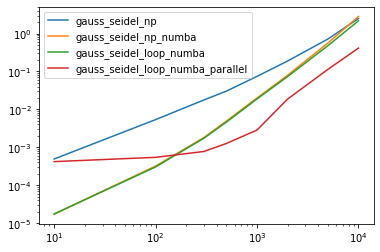

In [155]:
curve(
    gauss_seidel_np,
    gauss_seidel_np_numba,
    gauss_seidel_loop_numba,
    gauss_seidel_loop_numba_parallel
)

We have written a parallel version of Gauss-Seidel with different semantics, but which nonetheless converges, and does so quite fast !

The graph above tells us 3 things:
1. Numba spotted the loop fusions in the numpy code (there is no difference between gauss_seidel_np_numba and gauss_seidel_loop_numba)
2. Numba's advantage weakens with problem size
3. Parallelism is a game changer for Gauss-Seidel